In [ ]:
import pyam
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [61]:
#pyam.iiasa.platforms()
conn = pyam.iiasa.Connection("ar6-public")
#conn.valid_connections

[INFO] 16:30:13 - pyam.iiasa: You are connected to the IXSE_AR6_PUBLIC scenario explorer hosted by IIASA. If you use this data in any published format, please cite the data as provided in the explorer guidelines: https://data.ece.iiasa.ac.at/ar6/#/about
[INFO] 16:30:13 - pyam.iiasa: You are connected as user `bensan`


In [42]:
vars=conn.variables()

In [115]:
from IPython.display import display, HTML
import pandas as pd

search_terms = ["CCS"]
pattern = "(?=.*" + ")(?=.*".join(search_terms) + ")"
filtered = vars[vars.str.contains(pattern, regex=True)]

# Configure pandas to display long lines without truncation
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

# Display in a scrollable container
display(HTML(f"""
<div style="max-height: 300px; overflow-y: auto; overflow-x: auto; white-space: nowrap; font-family: monospace; padding: 10px; border: 1px solid #ccc;">
{filtered.to_frame().to_html(escape=False)}
</div>
"""))

,variable
93,Capacity Additions|Electricity|Biomass|w/ CCS
94,Capacity Additions|Electricity|Biomass|w/o CCS
96,Capacity Additions|Electricity|Coal|w/ CCS
97,Capacity Additions|Electricity|Coal|w/o CCS
100,Capacity Additions|Electricity|Gas|w/ CCS
101,Capacity Additions|Electricity|Gas|w/o CCS
107,Capacity Additions|Electricity|Oil|w/ CCS
108,Capacity Additions|Electricity|Oil|w/o CCS
120,Capacity|Electricity|Biomass|w/ CCS
121,Capacity|Electricity|Biomass|w/o CCS


In [235]:
df = conn.query(
    variable=["Carbon Sequestration|CCS","Carbon Sequestration|Land Use", "Carbon Sequestration|Direct Air Capture", "Emissions|CO2", "AR6 climate diagnostics|Surface Temperature (GSAT)|FaIRv1.6.2|50.0th Percentile",'Primary Energy|Oil','Primary Energy|Gas','Primary Energy|Coal'],
    region="World",
)

In [236]:
num_scenarios = df.data["scenario"].nunique()
print(f"Number of scenarios in df: {num_scenarios}")

Number of scenarios in df: 963


In [237]:
# Filter the dataframe using pyam's filter method for meta criteria
df = df.filter(Category=["C4", "C7", "C2", "C1", "C3", "C5", "C6"])

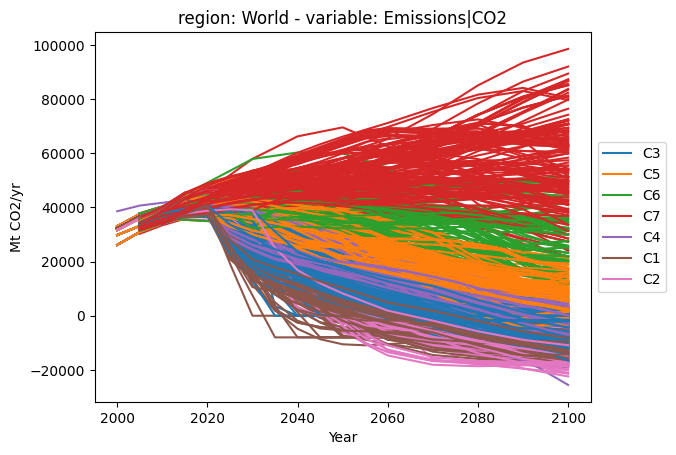

In [238]:
ax = df.filter(variable="Emissions|CO2").plot(
    color="Category", legend=dict(loc="center left", bbox_to_anchor=(1.0, 0.5))
)

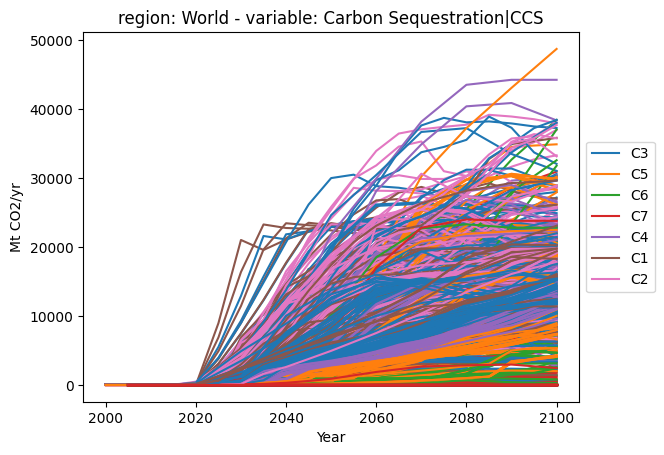

In [239]:
ax = df.filter(variable="Carbon Sequestration|CCS").plot(
    color="Category", legend=dict(loc="center left", bbox_to_anchor=(1.0, 0.5))
)

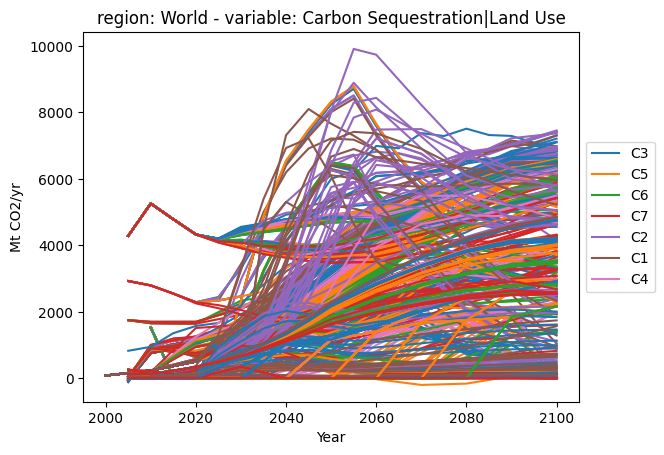

In [240]:
ax = df.filter(variable="Carbon Sequestration|Land Use").plot(
    color="Category", legend=dict(loc="center left", bbox_to_anchor=(1.0, 0.5))
)

In [241]:
def pivtab(x,catg='*'):
  tb={}
  itmp=[]
  vs=x.variable
  years=[2020,2030,2040,2050,2060,2070,2080,2090,2100]
  for vrb in vs:
    print(vrb)
    filtb=x.filter(variable=vrb,Category=catg).data
    unt=filtb.unit.unique()

    tmp=pd.pivot_table(filtb,index=['model','scenario'],columns='year',values=['value'])['value'][years].T
    unt=unt[0][:]
    tb[vrb]=tmp
    tb[vrb].unit=unt
    itmp.append(tmp.index)
  ii=tb[list(tb)[0]].index
  for ij,vrb in enumerate(vs):
    ii=ii.intersection(itmp[ij])
  for vrb in vs:
    unt=tb[vrb].unit
    tb[vrb]=tb[vrb].loc[ii]
    tb[vrb].unit=unt
    tb[vrb].name=vrb
  return tb

In [242]:
data=pivtab(df)

AR6 climate diagnostics|Surface Temperature (GSAT)|FaIRv1.6.2|50.0th Percentile
Carbon Sequestration|CCS
Carbon Sequestration|Direct Air Capture
Carbon Sequestration|Land Use
Emissions|CO2
Primary Energy|Coal
Primary Energy|Gas
Primary Energy|Oil


In [243]:
# Find the subset of columns (years) that exist in all dataframes in 'data'
common_columns = set.intersection(*(set(df.columns) for df in data.values()))


In [244]:
# Filter each dataframe in 'data' to include only columns in 'common_columns'
filtered_data = {k: v.loc[:, list(common_columns)] for k, v in data.items()}

In [245]:
# Linearly interpolate each dataframe in filtered_data to annual intervals between 2020 and 2100
annual_years = list(range(2020, 2101))
interpolated_data = {
    k: v.reindex(annual_years).interpolate(axis=0)
    for k, v in filtered_data.items()
}

In [296]:
removals=(interpolated_data['Carbon Sequestration|CCS']+interpolated_data['Carbon Sequestration|Land Use']+interpolated_data['Carbon Sequestration|Direct Air Capture'])/1000/44*12

In [247]:
temp=interpolated_data['AR6 climate diagnostics|Surface Temperature (GSAT)|FaIRv1.6.2|50.0th Percentile']

In [292]:
emissions=interpolated_data['Emissions|CO2']/1000/44*12

In [249]:
t2100 = temp.iloc[-1]

Text(0.5, 1.0, 'Cumulative Emissions vs Removals colored by 2100 Temperature')

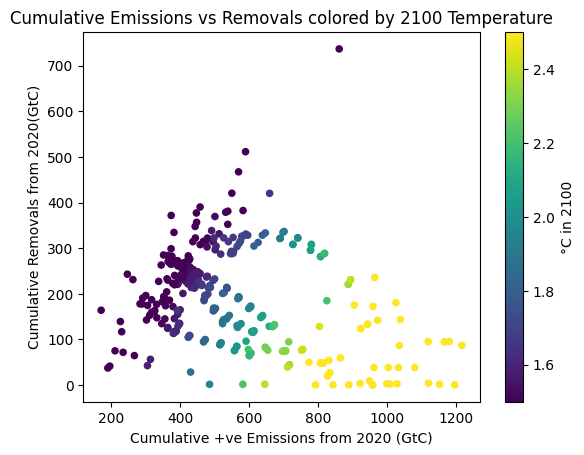

In [297]:
plt.scatter((emissions+removals).sum(),removals.sum(),20,t2100)
plt.clim(1.5, 2.5)
plt.colorbar(label='°C in 2100')
plt.xlabel('Cumulative +ve Emissions from 2020 (GtC)')
plt.ylabel('Cumulative Removals from 2020(GtC)')
plt.title('Cumulative Emissions vs Removals colored by 2100 Temperature')

Text(0, 0.5, 'Primary Energy from Gas (EJ)')

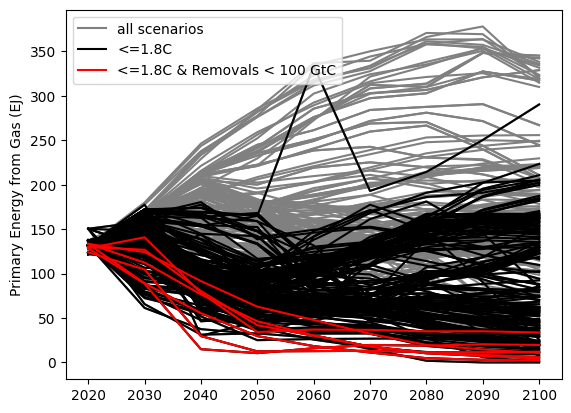

In [326]:
yrs=list(interpolated_data['Primary Energy|Gas'].index)
p1=plt.plot(yrs,interpolated_data['Primary Energy|Gas'].loc[:, :],color='grey',label='all scenarios')
p2=plt.plot(yrs,interpolated_data['Primary Energy|Gas'].loc[:, temp.columns[(temp <= 1.8).all(axis=0)]],color='black',label='<=1.8C')
p3=plt.plot(yrs,interpolated_data['Primary Energy|Gas'].loc[:, temp.columns[(temp <= 1.8).all(axis=0) & (removals.sum()<100)]],color='r',label='<=1.8C & Removals < 100 GtC')
plt.legend([p1[0],p2[0],p3[0]],['all scenarios','<=1.8C','<=1.8C & Removals < 100 GtC'])
plt.ylabel('Primary Energy from Gas (EJ)')


In [384]:
removal_bins=[0, 100, 200, 300, 400, 500]
emission_bins=[100, 200, 300, 400, 500, 600, 700, 800, 900,1000,1100,1200]


In [366]:

# Calculate summed positive emissions and summed removals for each scenario
total_positive_emissions = (emissions + removals).sum()
total_removals = removals.sum()

# Flatten the MultiIndex for easier handling
# Since total_positive_emissions is a Series, we use .index instead of .columns
scenario_labels = [f"{m}__{s}" for m, s in total_positive_emissions.index]

# Create a DataFrame with summed values for each scenario
classification_df = pd.DataFrame({
    'scenario': scenario_labels,
    'positive_emissions': total_positive_emissions.values,
    'removals': total_removals.values
})

# Bin the scenarios according to the provided bins
classification_df['emission_bin'] = pd.cut(classification_df['positive_emissions'], emission_bins, right=False)
classification_df['removal_bin'] = pd.cut(classification_df['removals'], removal_bins, right=False)

classification_df.head()

,scenario,positive_emissions,removals,emission_bin,removal_bin
0,REMIND-MAgPIE 2.1-4.2__EN_INDCi2030_1000f_COV_NDCp,386.341926,117.949466,"[300, 400)","[100, 200)"
1,REMIND-MAgPIE 2.1-4.2__EN_NPi2020_2500,712.095097,39.782691,"[700, 800)","[0, 100)"
2,WITCH 5.0__EN_NPi2020_1600f,534.446026,144.677030,"[500, 600)","[100, 200)"
3,WITCH 5.0__EN_NPi2020_1000f,443.326005,215.153080,"[400, 500)","[200, 300)"
4,REMIND-MAgPIE 2.1-4.2__EN_NPi2020_1000_COV,380.771321,113.181387,"[300, 400)","[100, 200)"


In [367]:
# Add mean temperature in 2100 for each scenario in classification_df
# temp_below_1_8C contains temperature data for scenarios, with years as index and scenario/model as columns

# Get temperature in 2100 for each scenario/model in temp_below_1_8C
temp_2100 = temp.loc[2100]

# Map scenario/model labels to temp_2100 columns
# classification_df['scenario'] is formatted as "model__scenario"
temp_2100_map = {
    f"{model}__{scenario}": temp_2100[(model, scenario)]
    for model, scenario in temp_2100.index
    if (model, scenario) in temp_2100.index
}

# Add temperature in 2100 to classification_df
classification_df['temp_2100'] = classification_df['scenario'].map(temp_2100_map)

# For each bin, calculate the mean temperature in 2100 for scenarios in that bin
mean_temp_by_bin = classification_df.groupby(['emission_bin', 'removal_bin'])['temp_2100'].mean()



/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_59063/501824375.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_temp_by_bin = classification_df.groupby(['emission_bin', 'removal_bin'])['temp_2100'].mean()


In [436]:
def plot_binned_variable_by_emissions_removals(variable_series, classification_df, title=None, cmap='coolwarm', xlabel='Cumulative +ve Emissions Bin (GtC)', ylabel='Cumulative Removals Bin (GtC)', colorbar_label=None, aggregation='mean'):
    """
    Plots the mean or median value of a variable (e.g., temperature, emissions, etc.) in a 2D grid binned by cumulative emissions and removals.

    Parameters:
        variable_series (pd.Series): Series with scenario labels as index and variable values.
        classification_df (pd.DataFrame): DataFrame with 'scenario', 'emission_bin', 'removal_bin' columns.
        title (str): Plot title.
        cmap (str): Colormap for imshow.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        colorbar_label (str): Label for colorbar.
        aggregation (str): Either 'mean' or 'median' to specify how to aggregate values in each bin.
    """
    # Add variable to classification_df
    classification_df = classification_df.copy()
    temp_2100=variable_series
    temp_2100_map = {
    f"{model}__{scenario}": temp_2100[(model, scenario)]
    for model, scenario in temp_2100.index
    if (model, scenario) in temp_2100.index
    }
    classification_df['var_value'] = classification_df['scenario'].map(temp_2100_map)

    # Calculate aggregated value by bin (mean or median)
    if aggregation.lower() == 'median':
        agg_var_by_bin = classification_df.groupby(['emission_bin', 'removal_bin'])['var_value'].median()
    else:  # default to mean
        agg_var_by_bin = classification_df.groupby(['emission_bin', 'removal_bin'])['var_value'].mean()

    # Prepare grid for plotting
    emission_categories = classification_df['emission_bin'].cat.categories
    removal_categories = classification_df['removal_bin'].cat.categories
    
    # Get bin centers for proper positioning
    emission_centers = [(b.left + b.right) / 2 for b in emission_categories]
    removal_centers = [(b.left + b.right) / 2 for b in removal_categories]
    
    # Create labels showing bin ranges
    emission_bin_labels = [f"{int(b.left)}-{int(b.right)}" for b in emission_categories]
    removal_bin_labels = [f"{int(b.left)}-{int(b.right)}" for b in removal_categories]
    
    var_grid = agg_var_by_bin.unstack().T.values

    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Use the actual bin centers as extent for imshow
    extent = [min(emission_centers) - (emission_centers[1] - emission_centers[0])/2,
              max(emission_centers) + (emission_centers[1] - emission_centers[0])/2,
              min(removal_centers) - (removal_centers[1] - removal_centers[0])/2,
              max(removal_centers) + (removal_centers[1] - removal_centers[0])/2]
    
    im = ax.imshow(var_grid, origin='lower', aspect='auto', cmap=cmap, extent=extent)

    # Set ticks at bin centers with proper labels
    ax.set_xticks(emission_centers)
    ax.set_yticks(removal_centers)
    ax.set_xticklabels(emission_bin_labels, rotation=45, ha='right')
    ax.set_yticklabels(removal_bin_labels)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    default_label = f'{aggregation.title()} Value' if colorbar_label is None else colorbar_label
    plt.colorbar(im, label=default_label)
    plt.tight_layout()
    return im,ax 

/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_59063/267943960.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_var_by_bin = classification_df.groupby(['emission_bin', 'removal_bin'])['var_value'].mean()


(0.0, 500.0)

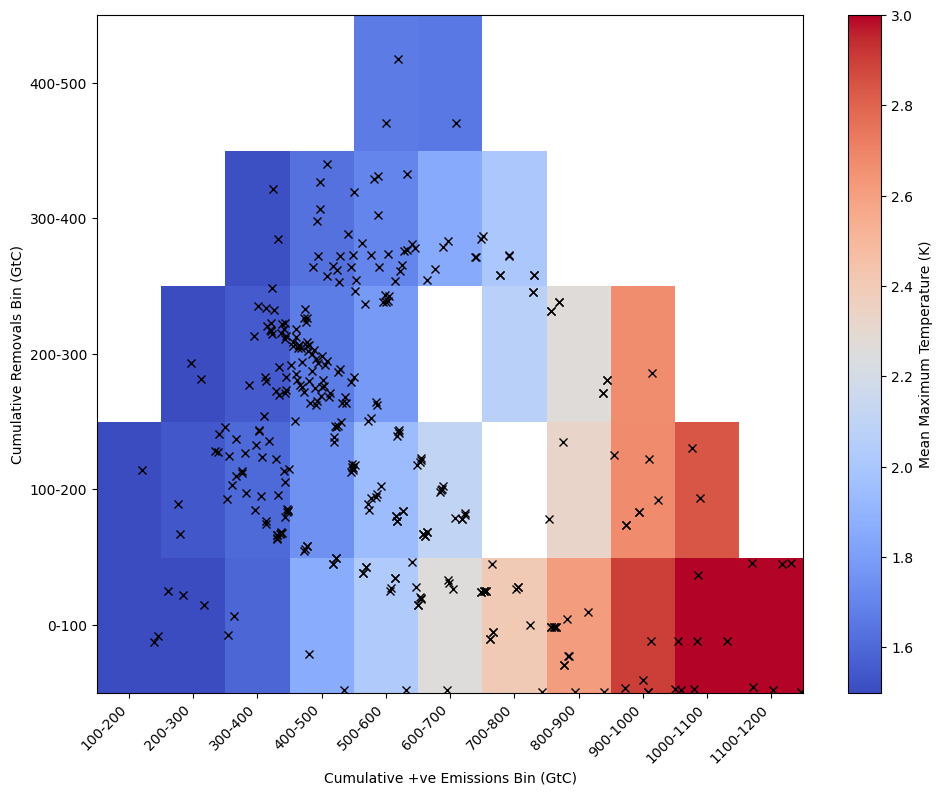

In [445]:
im,ax=plot_binned_variable_by_emissions_removals(temp.max(axis=0), classification_df,colorbar_label='Mean Maximum Temperature (K)')
im.set_clim(1.5,3)
ax.plot((emissions+removals).sum(),removals.sum(),'kx')
ax.set_xlim(100,1200)
ax.set_ylim(0,500)


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_59063/267943960.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_var_by_bin = classification_df.groupby(['emission_bin', 'removal_bin'])['var_value'].median()


Text(0.5, 1.0, 'Median Gas Energy Ratio by Emissions/Removals Bins')

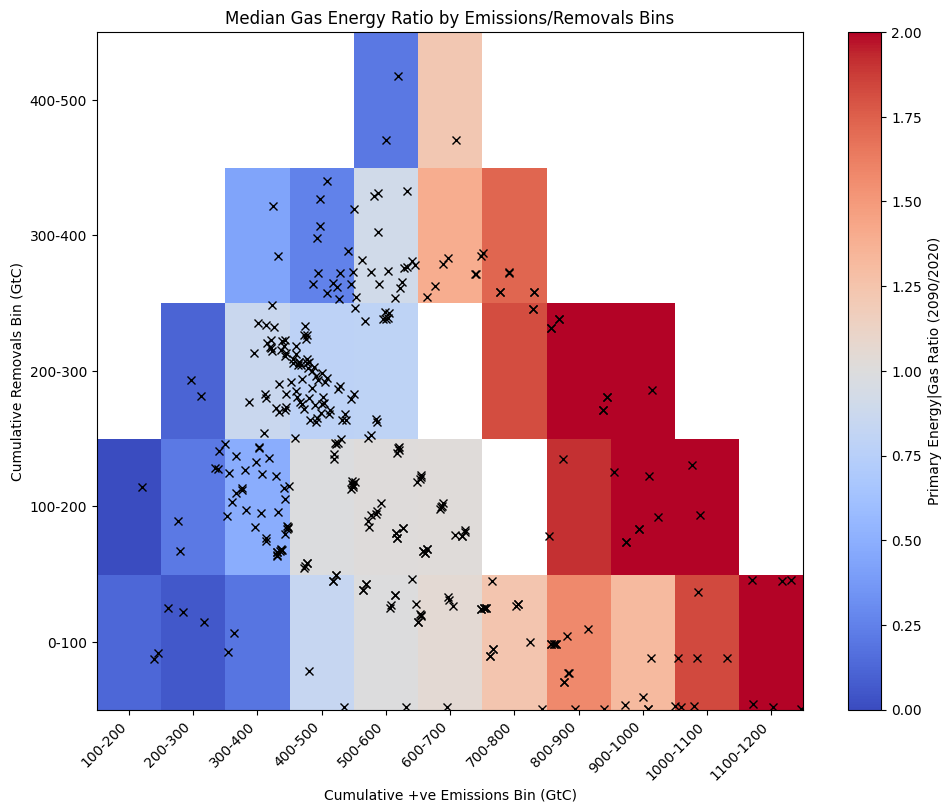

In [442]:
fracgas = interpolated_data['Primary Energy|Gas'].loc[2090] / interpolated_data['Primary Energy|Gas'].loc[2020]
im, ax = plot_binned_variable_by_emissions_removals(
    fracgas, 
    classification_df,
    colorbar_label='Primary Energy|Gas Ratio (2090/2020)', 
    aggregation='median'
)
im.set_clim(0, 2)
ax.plot((emissions+removals).sum(), removals.sum(), 'kx')
ax.set_xlim(100, 1200)
ax.set_ylim(0, 500)
ax.set_title('Median Gas Energy Ratio by Emissions/Removals Bins')